Importa biblioteca Pandas, chama de 'pd' e libera o acesso ao Google Drive

In [3]:
%pip install requests
%pip install geopandas
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 100.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 19.7 MB/s eta 0:00:00


In [4]:
import requests
import folium
import xml.etree.ElementTree as ET
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import numpy as np
import math
import geopandas as gpd
import rasterio
from shapely.geometry import Point, LineString, Polygon
import matplotlib as mpl
from scipy.spatial import Voronoi
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Configura o pandas para mostrar todas as colunas do dataframe
pd.options.display.max_columns = None


Mounted at /content/drive


Manipulação de DF em forma de função

In [5]:
def prepararDF(df, codigo):
  # Muda o tipo da coluna 'Data' para datetime (string --> datetime)
  df['Data'] = df['DataHora'][:10]
  df['Data'] = pd.to_datetime(df['Data'], format='%Y/%m/%d')

  # A coluna 'Data' e 'NivelConsistencia' são usadas como índice
  df.set_index(['Data','NivelConsistencia'], inplace=True)

  # Exclui colunas desnecessárias do dataframe
  listColumnsDrop = []
  for i in range(77):
    if i > 44:
      listColumnsDrop += [i]
  listColumnsDrop += [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
  df = df.drop(df.columns[listColumnsDrop], axis=1)
  
  # Avalia se existe uma mesma data com diferentes níveis de consistência
  # Classificar o dataframe por data
  df.sort_values("Data", inplace=True)

  # Reseta os índices para passar "Data" como coluna e utilizar a mesma para apagar as linhas duplicadas
  df = df.reset_index()

  # apagas as linhas duplicadas, dando preferência ao dado consistido ('NivelConsistencia' = 2)
  df = df.drop_duplicates(subset='Data', keep='last', inplace=False)

  # A coluna 'Data' e 'NivelConsistencia' são usadas como índice
  df.set_index(['Data','NivelConsistencia'], inplace=True)

  # transforma as colunas de chuva em linhas com as respectivas datas
  # Este processo transforma todas as colunas em linhas, gerando um problema para os meses que possuem menos de 31 dias
  # Dessa forma, o dia 1 de um mês armazenava a chuva do dia 1 e a chuva do dia 31 (linha duplicada com valor NaN)
  # Correção explicada durante o processo:

  # usa a função .melt() para transformar todas as colunas em linhas. São mantidas as colunas ['Data', 'NivelConsistencia']
  # São criadas duas novas colunas: 'Dia' que recebe o nome da coluna que virou linha e 'Chuva' que recebe o valor que era armazenado na coluna
  df = df.reset_index().melt(id_vars=['Data', 'NivelConsistencia'], var_name='Dia', value_name='Chuva')

  # Fiz uma cópia da minha data em formato de texto
  df['Data1']=df['Data'].astype(str)

  # Apaguei os últimos 2 caracteres, assim ficou somente o texto com %Y-%m- ('1989-11-')
  df['Data1'] = df['Data1'].str[:-2]

  # Fiz uma cópia da coluna 'Dia' (exe: 'Chuva03'), a 'função .str.extract('(\d+)', expand=False)' deixa apenas os números
  # (então a coluna 'Dia1' armazena a string '03') ('Chuva03' --> '03')  
  df['Dia1'] = df['Dia'].str.extract('(\d+)', expand=False)
  
  # praticamente a mesma coisa da linha anterior, mudando apenas que substitui a própria coluna e o formato é int ('Chuva03' --> 3)
  df['Dia'] = df['Dia'].str.extract('(\d+)', expand=False).astype(int)

  # Como foram criadas várias linhas, tem vários índices repetidos da data, esta função soma os dias correspondente
  # aos da chuva guardado na coluna 'Dia' na data do índice (aqui é gerado o erro dos 31 dias)
  df['Data'] = df.apply(lambda x: x['Data'] + pd.DateOffset(days=x['Dia']-1), axis=1)

  # Aqui é feita uma concatenação do tipo '1989-11-'+'03' formando uma data.
  # Mas aqui também forma datas como '1989-02-31'
  df['Data1'] = df['Data1'] + df['Dia1']

  # A maioria das datas das colunas 'Data' e 'Data1' serão iguais, mas datas como '1989-02-31'
  # vão gerar valor NaT pois é um erro (exatamente nas linhas duplicadas)
  df['Data1'] = pd.to_datetime(df['Data1'], format='%Y-%m-%d', errors='coerce')

  # Aqui é apagada todas as linhas em que o erro NaT aparece na coluna 'Data1' (removendo os valores duplicados)
  df.dropna(inplace=True, subset=['Data1'])

  # reorganiza as colunas
  df = df[['Data', 'NivelConsistencia', 'Chuva']]

  # Classificar o dataframe por data
  df.sort_values("Data", inplace=True)

  # A coluna 'Data' e 'NivelConsistencia' são usadas como índice novamente
  #df.set_index(['Data'], inplace=True)
  df['Codigo'] = codigo
  return df

Obter dados de estações pluviométricas(2) de uma bacia(3) através de API
(trabalhando)

In [ ]:
#https://www.hashtagtreinamentos.com/o-que-e-uma-api-python?gclid=Cj0KCQiAx6ugBhCcARIsAGNmMbi3iOmaN0FmKdQR3RaduU3zTQfIQvKN3enrln7Xa2S7UW3zTftBECIaApFJEALw_wcB
#https://dadosaocubo.com/ingestao-de-dados-via-api-com-python/#:~:text=Requisi%C3%A7%C3%A3o%20de%20Dados%20da%20API,vamos%20deixar%20vazio%20neste%20momento).
#https://dadosabertos.ana.gov.br/documents/ae318ebacb4b41cda37fbdd82125078b/explore
#https://www.nylas.com/blog/use-python-requests-module-rest-apis/
#https://pandas.pydata.org/docs/reference/io.html#json

API Obtem todas as estações da sub-bacia

In [6]:
url = 'http://telemetriaws1.ana.gov.br/ServiceANA.asmx/HidroInventario'
params = {
    'codEstDE': '',
    'codEstATE': '',
    'tpEst': '2',
    'nmEst': '',
    'nmRio': '',
    'codSubBacia': '39',
    'codBacia': '',
    'nmMunicipio': '',
    'nmEstado': '',
    'sgResp': '',
    'sgOper': '',
    'telemetrica': ''
}
# Realiza a requisição GET para a URL fornecida, passando os parâmetros
response = requests.get(url, params=params)

In [7]:
xml = response.text

# Lê o XML e converte em um DataFrame utilizando o método read_xml do pandas
df = pd.read_xml(xml,
                 xpath="//Table",
                 namespaces={"xs": "http://www.w3.org/2001/XMLSchema"})

# Cria uma cópia do DataFrame df e atribui à variável dfTele
dfTele = df

# Seleciona apenas as colunas desejadas no DataFrame df
df = df[['Codigo', 'TipoEstacaoTelemetrica', 'PeriodoPluviometroInicio', 'PeriodoPluviometroFim', 'PeriodoTelemetricaInicio', 'PeriodoTelemetricaFim', 'MunicipioCodigo', 'nmMunicipio', 'Latitude', 'Longitude']]

# Define a coluna 'Codigo' como índice do DataFrame df
df.set_index(['Codigo'], inplace=True)

# Converte as colunas de datas para o formato datetime
df['PeriodoPluviometroInicio'] = pd.to_datetime(df['PeriodoPluviometroInicio'], format='%Y-%m-%d %H:%M:%S')
df['PeriodoPluviometroFim'] = pd.to_datetime(df['PeriodoPluviometroFim'], format='%Y-%m-%d %H:%M:%S')
df['PeriodoTelemetricaInicio'] = pd.to_datetime(df['PeriodoTelemetricaInicio'], format='%Y-%m-%d %H:%M:%S')
df['PeriodoTelemetricaFim'] = pd.to_datetime(df['PeriodoTelemetricaFim'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
#dfTele = dfTele.loc[dfTele['TipoEstacaoTelemetrica'] == 1]
dfTele

Adicionando geometria da sub-bacia

In [8]:
# Define o caminho para a pasta onde estão os arquivos
caminho_para_pasta = '/content/drive/MyDrive/ICD/Colab/Alexandre'

# Define o caminho para o arquivo contendo os polígonos das bacias
caminho_para_arquivo = '/geoft_bho_ach_otto_nivel_04.gpkg'

# Carrega os polígonos das bacias a partir do arquivo usando o geopandas
bacias = gpd.read_file(f'{caminho_para_pasta}{caminho_para_arquivo}')

# Filtra o dataframe de bacias para manter apenas as bacias com o valor '7596' na coluna 'wts_cd_pfafstetterbasin'
bacia_filtrada = bacias[bacias['wts_cd_pfafstetterbasin'] == '7596']

# Exibe o resultado do dataframe filtrado contendo apenas a bacia desejada
bacia_filtrada

,wts_pk,wts_cd_pfafstetterbasin,wts_cd_pfafstetterbasincodelevel,wts_gm_area,geometry
2324,1350862,7596,4,4404.61459,"MULTIPOLYGON (((-35.78083 -9.69929, -35.78327 ..."


In [9]:
# criar mapa com bacia filtrada
mapa = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=9)

# adicionar marcadores para cada coordenada
for index, row in df.iterrows():
    # definir cor do marcador com base no valor da coluna "TipoEstacaoTelemetrica"
    if row['TipoEstacaoTelemetrica'] == 1:
        cor = 'red'
        texto = 'C/Telemetria'
    else:
        cor = 'blue'
        texto = 'S/Telemetria'
    folium.Marker(location=[row['Latitude'], row['Longitude']], popup=f'Código:{index}'+'\n'+f'{texto}', icon=folium.Icon(color=cor)).add_to(mapa)

# adicionar polígonos como camada no mapa

folium.GeoJson(bacia_filtrada).add_to(mapa)

# exibir mapa
mapa

In [10]:
bacia_filtrada_buffer = bacia_filtrada.buffer(0.1) #Não sei que unidade de medida é essa do buffer
# criar mapa da bacia com buffer
mapa = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=9)

# adicionar marcadores para cada coordenada
for index, row in df.iterrows():
    # definir cor do marcador com base no valor da coluna "TipoEstacaoTelemetrica"
    if row['TipoEstacaoTelemetrica'] == 1:
        cor = 'red'
        texto = 'C/Telemetria'
    else:
        cor = 'blue'
        texto = 'S/Telemetria'
    folium.Marker(location=[row['Latitude'], row['Longitude']], popup=f'Código:{index}'+'\n'+f'{texto}', icon=folium.Icon(color=cor)).add_to(mapa)

# adicionar polígonos como camada no mapa

folium.GeoJson(bacia_filtrada_buffer).add_to(mapa)

# exibir mapa
mapa

<ipython-input-10-c20f6459e7ee>:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bacia_filtrada_buffer = bacia_filtrada.buffer(0.1) #Não sei que unidade de medida é essa do buffer


In [12]:
GDF = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
GDF_Filtrado = GDF[GDF.within(bacia_filtrada_buffer.geometry.iloc[0])]

In [13]:
# criar mapa
mapa = folium.Map(location=[GDF_Filtrado['Latitude'].mean(), GDF_Filtrado['Longitude'].mean()], zoom_start=9)

# adicionar marcadores para cada coordenada
for index, row in GDF_Filtrado.iterrows():
    # definir cor do marcador com base no valor da coluna "TipoEstacaoTelemetrica"
    if row['TipoEstacaoTelemetrica'] == 1:
        cor = 'red'
        texto = 'C/Telemetria'
    else:
        cor = 'blue'
        texto = 'S/Telemetria'
    folium.Marker(location=[row.geometry.y, row.geometry.x], popup=f'Código:{index}'+'\n'+f'{texto}', icon=folium.Icon(color=cor)).add_to(mapa)

# adicionar polígonos como camada no mapa

folium.GeoJson(bacia_filtrada_buffer).add_to(mapa)

# exibir mapa
mapa

In [14]:
DF_Filtrado = GDF_Filtrado.drop('geometry', axis=1).copy()

In [15]:
# API para solicitar dados de estações sem telemetria
dfRequest = DF_Filtrado[DF_Filtrado['TipoEstacaoTelemetrica'] == 0]

frames = []
for estacao in list(dfRequest.index):
  url = 'http://telemetriaws1.ana.gov.br/ServiceANA.asmx/HidroSerieHistorica'
  params = {
      'codEstacao': estacao,
      'dataInicio': '',
      'dataFim': '',
      'tipoDados': '2',
      'nivelConsistencia': '',
  }
  try:
    response = requests.get(url, params=params)
    xml = response.text
    df1 = pd.read_xml(xml,
                      xpath="//SerieHistorica",
                      namespaces={"xs": "http://www.w3.org/2001/XMLSchema"})
  except ValueError:
    pass
  else:
    response = requests.get(url, params=params)
    xml = response.text
    df1 = pd.read_xml(xml,
                      xpath="//SerieHistorica",
                      namespaces={"xs": "http://www.w3.org/2001/XMLSchema"})
    df1 = prepararDF(df1, estacao)
    #df1.reset_index()
    frames += [df1]
dfEstacoesST = pd.concat(frames)
print(f'Foram carregadas {len(frames)} estações')
dfEstacoesST

Foram carregadas 42 estações


,Data,NivelConsistencia,Chuva,Codigo
0,1988-09-01,1,14.0,835073
11,1988-09-02,1,12.2,835073
22,1988-09-03,1,0.0,835073
33,1988-09-04,1,0.0,835073
44,1988-09-05,1,0.0,835073
...,...,...,...,...
295,2003-12-27,1,NaN,936091
306,2003-12-28,1,NaN,936091
317,2003-12-29,1,NaN,936091
328,2003-12-30,1,NaN,936091


In [16]:
dfEstacoesST = dfEstacoesST.dropna(subset=['Chuva'])
dfEstacoesST

,Data,NivelConsistencia,Chuva,Codigo
0,1988-09-01,1,14.0,835073
11,1988-09-02,1,12.2,835073
22,1988-09-03,1,0.0,835073
33,1988-09-04,1,0.0,835073
44,1988-09-05,1,0.0,835073
...,...,...,...,...
295,1958-12-27,1,0.0,936054
306,1958-12-28,1,0.0,936054
317,1958-12-29,1,0.0,936054
328,1958-12-30,1,0.0,936054


In [17]:
periodo = dfEstacoesST.set_index("Data").loc['1967-12-01':'1968-01-01']
#periodo = periodo.reset_index("Data")
periodo.head(30)

,NivelConsistencia,Chuva,Codigo
Data,,,
1967-12-01,1,0.0,836013
1967-12-02,1,0.0,836013
1967-12-03,1,0.0,836013
1967-12-04,1,0.0,836013
1967-12-05,1,0.0,836013
1967-12-06,1,0.0,836013
1967-12-07,1,3.6,836013
1967-12-08,1,0.0,836013
1967-12-09,1,0.0,836013


Grafico de GANTT

In [ ]:
df = dfEstacoesST

df = df.sort_values(["Codigo", "Data"])

grupos = []
seq_datas = []

for codigo, grupo in df.groupby("Codigo"):
    for i, data in enumerate(grupo["Data"]):
        if i == 0:
            seq_datas.append([data])
        else:
            if (data - grupo["Data"].iloc[i-1]) == timedelta(days=1):
                seq_datas[-1].append(data)
            else:
                seq_datas.append([data])
    for seq in seq_datas:
        grupos.append({
            "Task": codigo,
            "Start": seq[0],
            "Finish": seq[-1]
        })
    seq_datas = []

df_grupos = pd.DataFrame(grupos)
df_grupos

In [19]:
fig = ff.create_gantt(df_grupos, show_colorbar=False,
                      group_tasks=True)
fig.show()

In [ ]:
# obtenha os limites da geometria
bounds = bacia_filtrada_buffer.total_bounds

# calcule as coordenadas do ponto superior esquerdo e inferior direito
x1, y1, x2, y2 = bounds[0], bounds[3], bounds[2], bounds[1]

# crie as tuplas com as coordenadas dos pontos
point1 = (x1, y1)
point2 = (x2, y2)

# exiba as coordenadas dos pontos
print(point1, point2)

(-36.7461265079, -8.6004439008) (-35.6412594489, -9.8206369136)


Daqui em diante não é necessário para a atividade. Foi lido e apresentado um raster com dados de chuva. Foi feito também um polígono de Thiessen


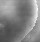

In [ ]:
caminho_para_pasta = '/content/drive/MyDrive/ICD/Colab/Alexandre'
caminho_para_arquivo = '/GIOVANNI-g4.timeAvgMap.GPM_3IMERGDF_06_precipitationCal.20000101-20100101.38W_10S_34W_6S.tif'


# Carrega o arquivo .tif
tif_file = rasterio.open(f'{caminho_para_pasta}{caminho_para_arquivo}')

# Extrai as coordenadas de canto inferior esquerdo e superior direito
left, bottom, right, top = tif_file.bounds

# Cria um mapa Folium centrado nas coordenadas do arquivo .tif
mapa = folium.Map(location=[(top+bottom)/2, (left+right)/2], zoom_start=10)

# Adiciona o arquivo .tif ao mapa como um layer de imagem
folium.raster_layers.ImageOverlay(
    image=tif_file.read(1),
    bounds=[[bottom, left], [top, right]],
    opacity=0.7,
    name='GPM_Precipitation'
).add_to(mapa)

# Exibe o mapa

mapa


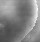

In [ ]:
# criar mapa
mapa = folium.Map(location=[GDF_Filtrado['Latitude'].mean(), GDF_Filtrado['Longitude'].mean()], zoom_start=9)

# adicionar marcadores para cada coordenada
for index, row in GDF_Filtrado.iterrows():
    # definir cor do marcador com base no valor da coluna "TipoEstacaoTelemetrica"
    if row['TipoEstacaoTelemetrica'] == 1:
        cor = 'red'
        texto = 'C/Telemetria'
    else:
        cor = 'blue'
        texto = 'S/Telemetria'
    folium.Marker(location=[row.geometry.y, row.geometry.x], popup=f'Código:{index}'+'\n'+f'{texto}', icon=folium.Icon(color=cor)).add_to(mapa)

# adicionar polígonos como camada no mapa
folium.GeoJson(bacia_filtrada_buffer).add_to(mapa)

# adicionar imagem ao mapa
folium.raster_layers.ImageOverlay(
    image=tif_file.read(1),
    bounds=[[bottom, left], [top, right]],
    opacity=0.7,
    name='GPM_Precipitation',
    #colormap=colormap,
    zindex=1
).add_to(mapa)

# exibir mapa
mapa

Obtem valor do raster através das coordenadas

In [ ]:
# read all the data from the first band
z = tif_file.read()[0]

# check the crs of the data
print(tif_file.crs)
# >>> CRS.from_epsg(4326)

# check the bounding-box of the data
print(tif_file.bounds)


# since the raster is in regular lon/lat grid (4326) we can use 
# `dat.index()` to identify the index of a given lon/lat pair
# (e.g. it expects coordinates in the native crs of the data)

def getval(lon, lat):
    idx = tif_file.index(lon, lat, precision=1E-6)    
    return tif_file.xy(*idx), z[idx]

getval(-36, -9)

EPSG:4326
BoundingBox(left=-38.50000088031475, bottom=-10.60000369765731, right=-34.499997194806284, top=-6.399999827873416)


/usr/local/lib/python3.10/dist-packages/rasterio/transform.py:124: RasterioDeprecationWarning:

The precision parameter is unused, deprecated, and will be removed in 2.0.0.



((-36.04999862294081, -8.950002177385066), 1.8341641)

Criando poligonos de thiessen para delimitar áreas

In [ ]:
# Extrai as coordenadas dos pontos do geodataframe "GDF_Filtrado"
coords = list(GDF_Filtrado.geometry.apply(lambda p: p.coords[0]))

# Cria o objeto "Voronoi" a partir das coordenadas dos pontos
vor = Voronoi(coords)

# Cria uma lista de polígonos a partir dos vértices das regiões de Voronoi
polygons = []
for region in vor.regions:
    if len(region) > 0 and -1 not in region:
        polygon = [vor.vertices[i] for i in region]
        polygons.append(polygon)

# Cria o geodataframe com os polígonos de Voronoi
poly_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries([Polygon(p) for p in polygons]))

# Define o sistema de coordenadas do geodataframe a partir do geodataframe "bacia_filtrada_buffer"
poly_gdf.crs = bacia_filtrada_buffer.crs

# Cria um novo geodataframe com os polígonos de Voronoi recortados pela bacia hidrográfica
poly_gdf_recortado = poly_gdf.intersection(bacia_filtrada_buffer.geometry.iloc[0])

# Define o sistema de coordenadas do geodataframe a partir do geodataframe "bacia_filtrada_buffer"
poly_gdf_recortado.crs = bacia_filtrada_buffer.crs

In [ ]:
# criar mapa
mapa = folium.Map(location=[GDF_Filtrado['Latitude'].mean(), GDF_Filtrado['Longitude'].mean()], zoom_start=9)

# adicionar marcadores para cada coordenada
for index, row in GDF_Filtrado.iterrows():
    # definir cor do marcador com base no valor da coluna "TipoEstacaoTelemetrica"
    if row['TipoEstacaoTelemetrica'] == 1:
        cor = 'red'
        texto = 'C/Telemetria'
    else:
        cor = 'blue'
        texto = 'S/Telemetria'
    folium.Marker(location=[row.geometry.y, row.geometry.x], popup=f'Código:{index}'+'\n'+f'{texto}', icon=folium.Icon(color=cor)).add_to(mapa)
    
# adicionar polígonos como camada no mapa
folium.GeoJson(bacia_filtrada_buffer).add_to(mapa)
# adicionar polígonos como camada no mapa
folium.GeoJson(poly_gdf_recortado).add_to(mapa)

# exibir mapa
mapa